In [1]:
import datetime
import folium
import importlib
import pandas as pd
import statistics
import tqdm

import SaveEcoBotFinder
import IdMatcher
import CamsWrapper

importlib.reload(SaveEcoBotFinder)
importlib.reload(IdMatcher)
importlib.reload(CamsWrapper)

from SaveEcoBotFinder import SaveEcoBotFinder
from IdMatcher import IdMatcher
from CamsWrapper import CamsWrapper

MATCHER = IdMatcher("співставлення ID постів з ID Cams.csv", bannedStations=[])
FINDER = SaveEcoBotFinder("/media/osamoile/data/Ecobot_16_11_2020")
CAMS = CamsWrapper("Cams_2019_2020_pm2.5_Kyiv.csv")

In [2]:
# PATH = "/media/osamoile/data/Ecobot_16_11_2020_pm25_noDuplicates/"
# full = []
# for f in tqdm.tqdm(os.listdir(PATH)):
#     df = pd.read_csv(PATH + f)
#     full.append(df)

# fullDf = pd.concat(full)
# fullDf.to_csv("/media/osamoile/data/all_posts.csv", index=False)

fullDf = pd.read_csv("/media/osamoile/data/all_posts.csv")
fullDf.sort_values(by=["date", "hour", "minute", "second"], inplace=True)
fullDf

,device_id,phenomenon,value,logged_at,value_text,date,hour,minute,second
2057952,28,pm25,14.2200,2019-03-10 00:03:38,NaN,2019-03-10,0,3,38
2482767,30,pm25,24.0200,2019-03-10 00:03:46,NaN,2019-03-10,0,3,46
2057953,28,pm25,14.9200,2019-03-10 00:06:09,NaN,2019-03-10,0,6,9
2482768,30,pm25,22.6000,2019-03-10 00:06:14,NaN,2019-03-10,0,6,14
2057954,28,pm25,15.2000,2019-03-10 00:08:37,NaN,2019-03-10,0,8,37
...,...,...,...,...,...,...,...,...,...
8228593,13141,pm25,29.9500,2020-11-16 22:13:39,NaN,2020-11-16,22,13,39
8470855,13802,pm25,40.3462,2020-11-16 22:13:39,NaN,2020-11-16,22,13,39
11191987,13207,pm25,28.1667,2020-11-16 22:13:39,NaN,2020-11-16,22,13,39
15455361,13208,pm25,29.6296,2020-11-16 22:13:39,NaN,2020-11-16,22,13,39


In [3]:
camsDf = pd.read_csv("/media/osamoile/data/cams_df.csv")
camsDf

,date,cams_id,hour,value
0,2020-08-26,6192,0,3.590714
1,2020-08-26,6192,1,4.083290
2,2020-08-26,6192,2,4.616537
3,2020-08-26,6192,3,5.084233
4,2020-08-26,6192,4,5.483605
...,...,...,...,...
177979,2019-06-12,6749,19,17.456409
177980,2019-06-12,6749,20,17.511955
177981,2019-06-12,6749,21,17.974079
177982,2019-06-12,6749,22,16.794783


In [4]:
def postCamsComparison(post_id: int, hour: int):
    # get 1 line per day (at HOUR o'clock) for every post
    singleStationSingleHourPerDay = fullDf[(fullDf.device_id == post_id) &
                                           (fullDf.hour == hour)].groupby(fullDf.date).first()
    # Filter satellite data for same dates
    camsIdForPost = MATCHER.getCamsIdByPostId(post_id)
    camsSingleValuePerDay = camsDf[(camsDf.date.isin(singleStationSingleHourPerDay.date.unique())) &
                                   (camsDf.cams_id == camsIdForPost) &
                                   (camsDf.hour == hour)]
    camsSingleValuePerDay = camsSingleValuePerDay.sort_values(by=["date"])
    camsSingleValuePerDay
    # Merge land and sattelite data into a single table
    singleStationSingleHourPerDay = singleStationSingleHourPerDay.set_index("date").join(camsSingleValuePerDay
        .rename(columns={"value": "cams_pm25"})
        .drop(columns=["hour"])
        .set_index("date"), on="date")
    singleStationSingleHourPerDay = singleStationSingleHourPerDay.reset_index()
    return singleStationSingleHourPerDay



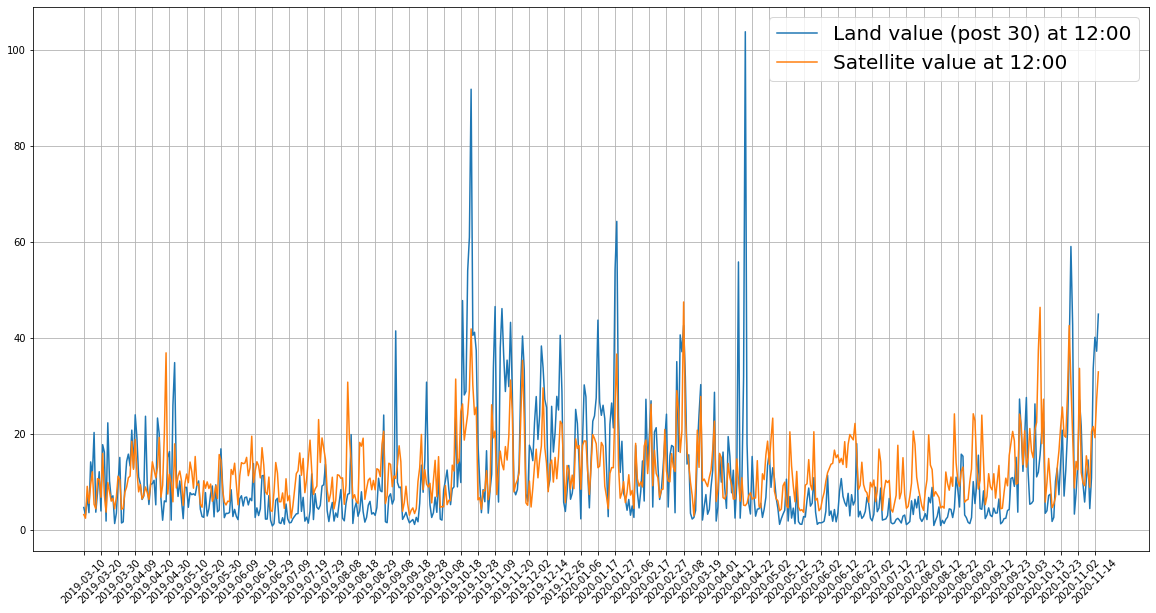

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot(df: pd.DataFrame, post_id: int, hour: int):
    fig, ax = plt.subplots(figsize=(20, 10))
    label = list(df.date)
    ax.plot(label, df.value, label='Land value (post %d) at %d:00' % (post_id, hour))
    ax.plot(label, df.cams_pm25, label='Satellite value at %d:00' % hour)
    ax.legend(loc='upper right', prop={'size': 20})
    ax.grid()
    plt.xticks(rotation=45)
    ax.set_xticks(np.arange(0, len(label)+1, 10))
    plt.show()

def dump(df: pd.DataFrame, post_id: int, hour: int):
    df[["value", "cams_pm25"]].to_csv('./correlation/post_%d_at_%d:00.csv' % (post_id, hour), sep=' ', index=False)

post_id = 30
hour = 12
res = postCamsComparison(post_id, hour)
plot(res, post_id, hour)
dump(res, post_id, hour)

In [26]:
n = 1000000  #chunk row size
list_df = [fullDf[i:i+n] for i in range(0,fullDf.shape[0],n)]
for i in range(len(list_df)):
    list_df[i].to_csv("/media/osamoile/data/sort_by_time/all_posts_%d_of_%d.csv" % (i+1, len(list_df)))

In [28]:
fullDf_byPost = fullDf.sort_values(["device_id", "logged_at"])
list_df = [fullDf_byPost[i:i+n] for i in range(0,fullDf_byPost.shape[0],n)]
for i in range(len(list_df)):
    list_df[i].to_csv("/media/osamoile/data/sort_by_time/all_posts_%d_of_%d.csv" % (i+1, len(list_df)))

,device_id,phenomenon,value,logged_at,value_text,date,hour,minute,second
2057952,28,pm25,14.22,2019-03-10 00:03:38,NaN,2019-03-10,0,3,38
2057953,28,pm25,14.92,2019-03-10 00:06:09,NaN,2019-03-10,0,6,9
2057954,28,pm25,15.20,2019-03-10 00:08:37,NaN,2019-03-10,0,8,37
2057955,28,pm25,14.76,2019-03-10 00:11:05,NaN,2019-03-10,0,11,5
2057956,28,pm25,14.54,2019-03-10 00:13:33,NaN,2019-03-10,0,13,33
...,...,...,...,...,...,...,...,...,...
6409452,13853,pm25,9.93,2020-11-16 22:01:03,NaN,2020-11-16,22,1,3
6409453,13853,pm25,9.14,2020-11-16 22:03:32,NaN,2020-11-16,22,3,32
6409454,13853,pm25,9.41,2020-11-16 22:06:02,NaN,2020-11-16,22,6,2
6409455,13853,pm25,10.38,2020-11-16 22:08:37,NaN,2020-11-16,22,8,37
